In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import bisect, fixed_point, newton
from scipy.stats import entropy
from scipy.integrate import dblquad
from scipy.integrate import quad
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from scipy.misc import logsumexp
from itertools import product

# Paper : An Information Geometry of Statistical Manifold Learning

Hyper-parameters : 

* Choose NN : NN corresponds to kNN in the paper (type: integer), it is set to 100 in the experiments section of the paper
* Choose k (k<NN) : k corresponds to k in the paper (type:integer), it is set to 50 in the experiments section of the paper

* Choose ks  (ks < k) : ks corresponds to ks in the paper (type: integer), it is set to 5 in the experiments section of the paper

let Y be original data matrix, let Z be embedding matrix, the following are the steps to compute the distance between Y amd Z :

- construct distance matrix (euclidean) between pairs of points for Y and for Z
- for a given a, b with a > 0, b > 0 we compute the density(see figure 3) using the following steps:

    * construct a mixture-distance matrix $a*s_{ij}^Y + b*s_{ij}^Z$ where $s_{ij}^Y$ is distance between 
      point i and j on Y and $s_{ij}^Z$ is distance between point i and j on Z
    * from that mixture-distance matrix retain only NN nearest neighbors for each point i
    * compute gaa, gab, gbb for each point i (Corrolary 10)
    * compute tau_i for Z and for Y (optimize tau_i for each point i to have an entropy of logk), 
     (section 4 of paper or look at SNE paper <http://www.cs.toronto.edu/~hinton/absps/sne.pdf>)
    * compute $vol(a,b)$ (equation 9)  : basically it measures linear correlation of the two embeddings, the more linearly                                     they are collected the smaller the volume is
    - compute $sigma(a,b)$ (proposition 13) : basically it measures the 'information density' at (a, b), "It means the amount of information a single observation possesses". A small information density 
    - compute $density(a, b)$ as $vol(a, b) * sig(a, b)$
- integrate $density(a,b)dadb$ for a and b with monte carlo numerical integration, 
  a and b are sampled so that 1/a and 1/b are in the interval [ks, k], so a and b are sampled uniformly from [1/k, 1/ks]
- after integrating we get our measure, "it can be understood as the linear
  agreement (of the two "models" (Y and Z)) at different scales weighted by information density" .

Talk : http://techtalks.tv/talks/an-information-geometry-of-statistical-manifold-learning/61044/

In [3]:
def softmax(w):
    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w - maxes)
    dist = e / np.sum(e, axis=1, keepdims=True)
    return dist
    
def entropy_p_univariate(s):
    log_norm = logsumexp(-s)
    log_p = - s - log_norm
    ent = (np.exp(log_p) * s).sum() + log_norm
    return ent

In [4]:
def construct_Gcov(S_Y, S_Z, S, NN=5):
    """
    Used to construct 'g_ab' in the paper
    """
    ind = S.argsort(axis=1)
    ind = ind[:, 1:NN + 1] # start by 1 because we dont want to count a point as neighbor to itself
    
    dist_Y = np.empty(ind.shape)
    for i in range(S_Y.shape[0]):
        dist_Y[i] = S_Y[i][ind[i]]
        
    dist_Z = np.empty(ind.shape)
    for i in range(S_Z.shape[0]):
        dist_Z[i] = S_Z[i][ind[i]]
    
    dist_S = np.empty(ind.shape)
    for i in range(S.shape[0]):
        dist_S[i] = S[i][ind[i]]
    
    P_S = softmax(-dist_S)
    Gcov = ((P_S * (dist_Y * dist_Z)).sum(axis=1) - 
            (P_S * dist_Y).sum(axis=1) * (P_S * dist_Z).sum(axis=1))
    return Gcov

def construct_Gvar(S_Y, S, NN=5):
    """
    Used to construct 'g_aa' and 'g_bb' in the paper
    """
    return construct_Gcov(S_Y, S_Y, S, NN=NN)

In [5]:
def construct_tau(S, k, NN=5, tau0=1, verbose=1):
    """
    find tau_i for each i which we scale the distances in row i so that the distribution in row i as entropy logk
    it is done in the paper with 'binary search' or more known as 'bisection method'. the goal of bisection method
    is to find the root of a function. what we want here for a row i is find tau_i so that :
    -\sum_j p_i(j)log p_i(j) = logk
    where p(j) is proba of j given i defined by equation 1 in paper but where the distances
    are scaled by tau_i
    I rather used a fixed point optimization algo instead of bisection, it works too.
    """
    tau = []
    for i in range(S.shape[0]):
        s = S[i]
        s = s[np.argsort(s)]
        s = s[1:NN + 1]
        def f(tau_sqrt):
            return entropy_p_univariate(s * tau_sqrt**2) - np.log(k) #+ tau_sqrt
        tau_sqrt_i = newton(f, tau0)
        tau_i = tau_sqrt_i ** 2
        if verbose > 0:
            print("row {}, entropy:{}, logk={}, tau:{}".format(i, entropy_p_univariate(s * tau_i), np.log(k), tau_i))
        tau.append(tau_i)
    tau = np.array(tau)
    return tau

In [6]:
def vol(tau_Y, tau_Z, gvar_Y, gvar_Z, gcov_YZ):
    """
    compute the vol term, it is defined in equation 9 of the paper
    """
    cov_term = (tau_Y * tau_Z * gcov_YZ).sum()
    var_Y_term = (tau_Y**2 * gvar_Y).sum()
    var_Z_term = (tau_Z**2 * gvar_Z).sum()
    return np.sqrt(1 - (cov_term**2) / (var_Y_term * var_Z_term))

def sig(tau_Y, tau_Z, gvar_Y, gvar_Z):
    """
    compute the \sigma term, it is defined after proposition 13 in the paper
    """
    var_Y_term = (tau_Y**2 * gvar_Y).sum()
    var_Z_term = (tau_Z**2 * gvar_Z).sum()
    return np.sqrt(var_Y_term) * np.sqrt(var_Z_term)

In [7]:
def build_density_func(S_Y, S_Z, tau_Y, tau_Z, NN=5):
    def compute(a, b):
        """
        compute density at (a, b). the measure proposed in the paper is a doule integration
        of the density computed in this function for a and b 
        """
        S = a * S_Y + b * S_Z
        g_ab = construct_Gcov(S_Y, S_Z, S)
        g_aa = construct_Gvar(S_Y, S)
        g_bb = construct_Gvar(S_Z, S)
        vol_ab = vol(tau_Y, tau_Z, g_aa, g_bb, g_ab)
        sig_ab = sig(tau_Y, tau_Z, g_aa, g_bb)
        return vol_ab * sig_ab
    return compute

In [21]:
def integrate_2d(func, a_range, b_range, nb_iter=100, verbose=1):
    """
    Generic 2d integration of func(a, b) with monte carlo using uniform sampling for a and b
    
    a_range : tuple defining of the interval to sample a from
    b_range : tuple defining of the interval to sample b from
    """
    val_mean = 0.
    for i in range(nb_iter):
        a = np.random.uniform(low=a_range[0], high=a_range[1])
        b = np.random.uniform(low=b_range[0], high=b_range[1])
        val = func(a, b)
        val_mean = (val + i * val_mean) / (i + 1)
    return val_mean * (a_range[1] - a_range[0]) * (b_range[1] - b_range[0])

In [89]:
def compute_dist(Y, Z, NN=100, k=10, ks=5, 
                 nb_iter=None, 
                 integration_method='quad',
                 compute_density=False, 
                 density_grid_size=10, 
                 nb_integrations=1,
                 verbose=1):
    S_Y = pairwise_distances(Y)
    S_Z = pairwise_distances(Z)
    tau_Y = construct_tau(S_Y, k=k, tau0=1, NN=NN, verbose=0)
    tau_Z = construct_tau(S_Z, k=k, tau0=1, NN=NN, verbose=0)
    get_density = build_density_func(S_Y, S_Z, tau_Y, tau_Z, NN=NN)
    
    if compute_density:
        a = np.linspace(1./k, 1./ks, density_grid_size)
        b = np.linspace(1./k, 1./ks, density_grid_size)
        density = np.empty((density_grid_size, density_grid_size))
        for i, j in product(np.arange(len(a)), np.arange(len(b))):
            density[i, j] = get_density(a[i], b[j])
    dists = []
    for i in range(nb_integrations):
        if integration_method == 'monte_carlo':
            if nb_iter is None:
                nb_iter = 100
            dist = integrate_2d(get_density, (1./k, 1./ks), (1./k, 1./ks), nb_iter=nb_iter, verbose=1)
        elif integration_method == 'quad':
            l = 1./k
            r = 1./ks
            dist, err = dblquad(get_density, l, r, lambda a:l, lambda a:r)
            if verbose > 0:
                print('quad integration abs error : {}'.format(err))
        else:
            raise ValueError('Invalid integration method : {}'.format(integration_method))
        dists.append(dist)
    if compute_density:
        return dists, density
    else:
        return dists, None

## Example computing distance measure (comparing PCA vs Isomap vs TSNE)

In [116]:
# These are the hyper-parameters of the distance measure

NN = 100 # nb of  neighbors
k = 50 # logk defines the entropy of tau_Y and tau_Z distributions
ks = 5 # "It can be chosen empirically as a rectangle to exclude 
       # low frequency information above the radius κ and high frequency
       #  information below a minimal radius ks"

In [91]:
Y, labels = make_swiss_roll(1000)

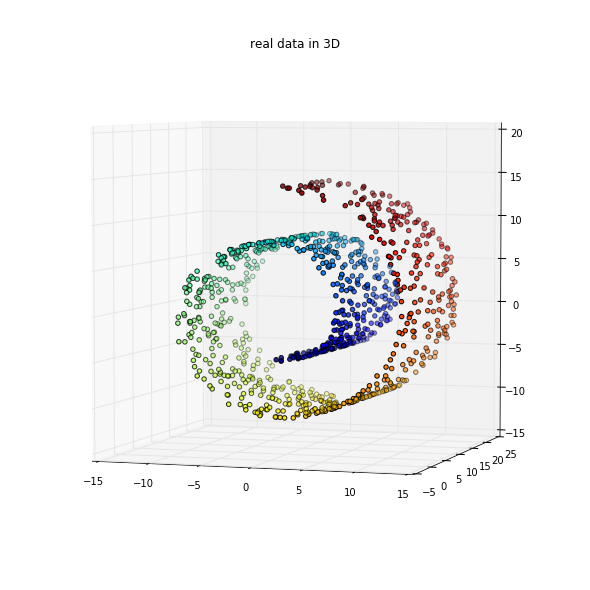

In [74]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=labels)
ax.view_init(4, -72)
plt.title('real data in 3D')
plt.show()

In [98]:
Z = PCA(n_components=2).fit_transform(Y)
T = Isomap(n_components=2).fit_transform(Y)

In [99]:
U = TSNE(n_components=2, init='pca', perplexity=50, verbose=1).fit_transform(Y)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.290146
[t-SNE] Error after 75 iterations with early exaggeration: 0.493701
[t-SNE] Error after 100 iterations: 0.467237


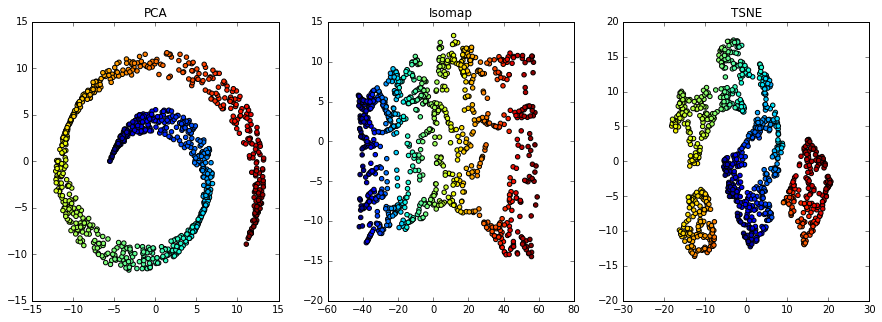

In [100]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(Z[:, 0], Z[:, 1], c=labels)
plt.title('PCA')

plt.subplot(1, 3, 2)
plt.scatter(T[:, 0], T[:, 1], c=labels)
plt.title('Isomap')

plt.subplot(1, 3, 3)
plt.scatter(U[:, 0], U[:, 1], c=labels)
plt.title('TSNE')
plt.show()

In [127]:
dist_Z, density_Z = compute_dist(Y, Z, NN=NN, k=k, ks=ks, 
                                 compute_density=True,
                                 nb_integrations=1, 
                                 integration_method='monte_carlo')
print(dist_Z, np.mean(dist_Z), np.std(dist_Z))
dist_Z = np.mean(dist_Z)

dist_T, density_T = compute_dist(Y, T, NN=NN, k=k, ks=ks, 
                                 compute_density=True, 
                                 nb_integrations=1, 
                                 integration_method='monte_carlo')
print(dist_T, np.mean(dist_T), np.std(dist_T))
dist_T = np.mean(dist_T)

dist_U, density_U = compute_dist(Y, U, NN=NN, k=k, ks=ks, 
                                 compute_density=True,
                                 nb_integrations=1, 
                                 integration_method='monte_carlo')
print(dist_U, np.mean(dist_U), np.std(dist_U))
dist_U = np.mean(dist_U)

print(sorted([dist_Z, dist_T, dist_U]))
print('dist to pca : {}'.format(dist_Z))
print('dist to isomap : {}'.format(dist_T))
print('dist to tsne : {}'.format(dist_U))

([4.3654361407323083], 4.3654361407323083, 0.0)
([1.7563157351894918e+21], 1.7563157351894918e+21, 0.0)
([1.1337687311983613], 1.1337687311983613, 0.0)
[1.1337687311983613, 4.3654361407323083, 1.7563157351894918e+21]
dist to pca : 4.36543614073
dist to isomap : 1.75631573519e+21
dist to tsne : 1.1337687312


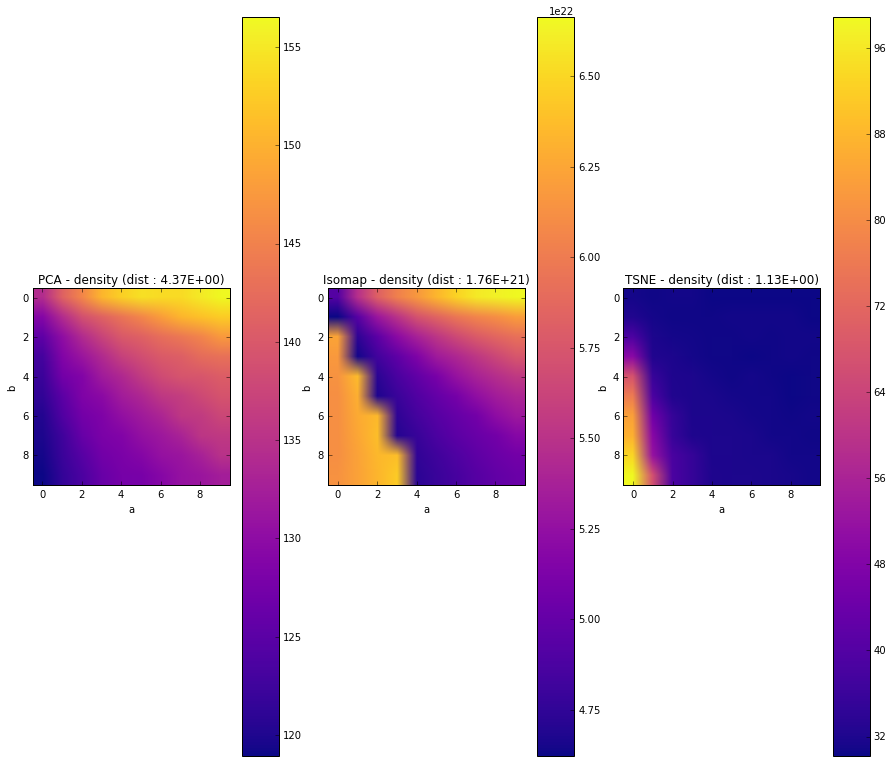

In [128]:
# display values of the density for a grid of a, b (like figure 3 in paper)
fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
ms = plt.imshow(density_Z, cmap='plasma')
cb = plt.colorbar(ms)
plt.xlabel('a')
plt.ylabel('b')
plt.title('PCA - density (dist : {:.2E})'.format(dist_Z))

plt.subplot(1, 3, 2)
ms = plt.imshow(density_T, cmap='plasma')
cb = plt.colorbar(ms)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Isomap - density (dist : {:.2E})'.format(dist_T))

plt.subplot(1, 3, 3)
ms = plt.imshow(density_U, cmap='plasma')
cb = plt.colorbar(ms)
plt.xlabel('a')
plt.ylabel('b')
plt.title('TSNE - density (dist : {:.2E})'.format(dist_U))
plt.show()

## Example estimating intrinsic dim of a model

In [117]:
def build_lai_func(S, idx=0, NN=5):
    """
    Compute g used by Local Accumulated information (LAI) for a given tau, definition 7 in the paper
    
    Local Accumulated information (LAI) is the integral of g by varying tau from 0 to +inf (definition 7 in the paper)
    """
    def compute(tau):
        S_tau = S * tau
        ind = S_tau[idx].argsort()
        ind = ind[1:NN+1]
        S_tau_idx = S_tau[idx][ind]
        P_S_taux_idx = softmax(-S_tau_idx[None, :])[0]
        
        m = (P_S_taux_idx * S_tau_idx**2).sum()
        n = (P_S_taux_idx * S_tau_idx).sum()**2
        
        if np.abs(m-n) <= 1e-8: # there is some numberical problem that makes m < n (with m very close to n) 
                                # while it should be m >= n
            return 0
        else:
            assert m >= n, (m, n)
            return np.sqrt(m - n)
    return compute

In [115]:
S_Y = pairwise_distances(Y)
nb_sampled_rows = 100
l = np.random.choice(np.arange(S_Y.shape[0]), nb_sampled_rows, replace=False)
val_mean = 0.
for i in l:
    get_lai = build_lai_func(S_Y, idx=i, NN=NN)
    val, _ = quad(get_lai, 0, np.inf)
    val_mean = (val + i * val_mean) / (i + 1)
print(val_mean)

lai = val_mean
assert lai >= np.arccos(1./NN) # lower bound 

AssertionError: (69449855.254729405, 69449855.25472942)